In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import cluster, metrics
from sklearn import manifold, decomposition
from sklearn.preprocessing import StandardScaler
pd.options.display.max_columns = 200
pd.options.display.max_rows = 100
import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")

In [2]:
data_brut = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')

In [3]:
data_brut.head(3)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."


In [4]:
A=data_brut.iloc[0,4]
B=A.split('>>')[0][2:-1]
B

'Home Furnishing'

In [118]:
data_brut['categorie']=data_brut['product_category_tree'].apply(lambda x : x.split('>>')[0][2:-1])
for i in data_brut['categorie'].unique():
    print(i)

Home Furnishing
Baby Care
Watches
Home Decor & Festive Needs
Kitchen & Dining
Beauty and Personal Care
Computers


In [6]:
data_brut['long']=data_brut['product_name']+data_brut['description']

In [7]:
data_text = data_brut[['uniq_id','long','categorie']]


In [8]:
data_img = data_brut[['uniq_id','categorie']]

# Partie Texte

In [9]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

def tokenizer_fct(sentence) :
    # print(sentence)
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

# Stop words
from nltk.corpus import stopwords
stop_w = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')']

def stop_word_filter_fct(list_words) :
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

# lower case et alpha
def lower_start_fct(list_words) :
    lw = [w.lower() for w in list_words if (not w.startswith("@")) 
    #                                   and (not w.startswith("#"))
                                       and (not w.startswith("http"))]
    return lw

# Lemmatizer (base d'un mot)
from nltk.stem import WordNetLemmatizer

def lemma_fct(list_words) :
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

# Fonction de préparation du texte pour le bag of words (Countvectorizer et Tf_idf, Word2Vec)
def transform_bow_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

# Fonction de préparation du texte pour le bag of words avec lemmatization
def transform_bow_lem_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

# Fonction de préparation du texte pour le Deep learning (USE et BERT)
def transform_dl_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
#    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(word_tokens)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

In [10]:
data_text['sentence_bow'] = data_text['long'].apply(lambda x : transform_bow_fct(x))
data_text['sentence_bow_lem'] = data_text['long'].apply(lambda x : transform_bow_lem_fct(x))
data_text['sentence_dl'] = data_text['long'].apply(lambda x : transform_dl_fct(x))
data_text.shape

(1050, 6)

In [11]:
from nltk.tokenize import sent_tokenize, word_tokenize

data_text['length_bow'] = data_text['sentence_bow'].apply(lambda x : len(word_tokenize(x)))
print("max length bow : ", data_text['length_bow'].max())
data_text['length_bl'] = data_text['sentence_bow_lem'].apply(lambda x : len(word_tokenize(x)))
print("max length bl : ", data_text['length_bl'].max())
data_text['length_dl'] = data_text['sentence_dl'].apply(lambda x : len(word_tokenize(x)))
print("max length dl : ", data_text['length_dl'].max())

max length bow :  383
max length bl :  383
max length dl :  636


In [12]:
l_cat = list(set(data_text['categorie']))
print("catégories : ", l_cat)
y_cat_num = [(1-l_cat.index(data_text.iloc[i]['categorie'])) for i in range(len(data_text))]

catégories :  ['Home Furnishing', 'Beauty and Personal Care', 'Home Decor & Festive Needs', 'Baby Care', 'Computers', 'Watches', 'Kitchen & Dining']


In [13]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cvect = CountVectorizer(stop_words='english', max_df=0.95, min_df=0.01)
ctf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=0.01)

feat = 'sentence_bow_lem'
cv_fit = cvect.fit(data_text[feat])
ctf_fit = ctf.fit(data_text[feat])

cv_transform = cvect.transform(data_text[feat])  
ctf_transform = ctf.transform(data_text[feat])  


In [14]:
import time
from sklearn import manifold, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.sparse import bsr_matrix
def kaiser_lim(pca):
    scree = pca.explained_variance_ratio_*100
    kaiser_lim=100/pca.n_components
    for i in range(len(scree)-1):
        if (scree[i] > kaiser_lim) & (scree[i+1] < kaiser_lim): 
            return i
    return pca.n_components
# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters

def ARI_fct(features) :
    time1 = time.time()
    num_labels=len(l_cat)
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, 
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_

# Calcul Tsne, détermination des clusters à partir des données de feautures 
def ARI_fct_1(features) :
    time1 = time.time()
    num_labels=len(l_cat)
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, 
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données avant TSNE
    scl=StandardScaler(with_mean=False).fit(features)
    pca = decomposition.SparsePCA(n_components=30)
    
    cls = KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    
    X_std=scl.transform(features)
    pca.fit(X_std.toarray())
    #lim=kaiser_lim(pca)
    X_std = pca.transform(X_std.toarray())
    #X_std = X_std[:,:lim]
    cls.fit(X_std)
    
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_

# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie")
    plt.title('Représentation des catégories réelles')
    plt.xlabel("1ere dim de TSNE")
    plt.ylabel("2eme dim de TSNE")
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des catégorie par clusters')
    plt.xlabel("1ere dim de TSNE")
    plt.ylabel("2eme dim de TSNE")
    plt.show()
    print("ARI : ", ARI)


CountVectorizer : 
-----------------
ARI :  0.0479 time :  115.0


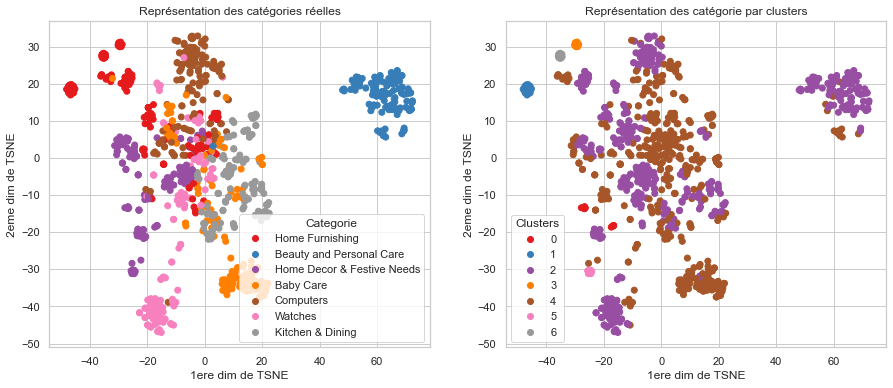

ARI :  0.0479


In [15]:
print("CountVectorizer : ")
print("-----------------")
ARI, X_tsne, labels = ARI_fct_1(cv_transform)
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)


CountVectorizer : 
-----------------
ARI :  0.4529 time :  12.0


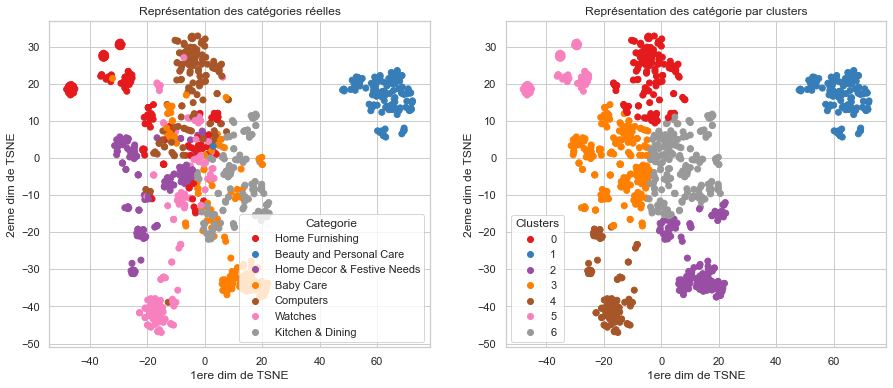

ARI :  0.4529


In [16]:
print("CountVectorizer : ")
print("-----------------")
ARI, X_tsne, labels = ARI_fct(cv_transform)
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

Tf-idf : 
--------
ARI :  0.5585 time :  10.0


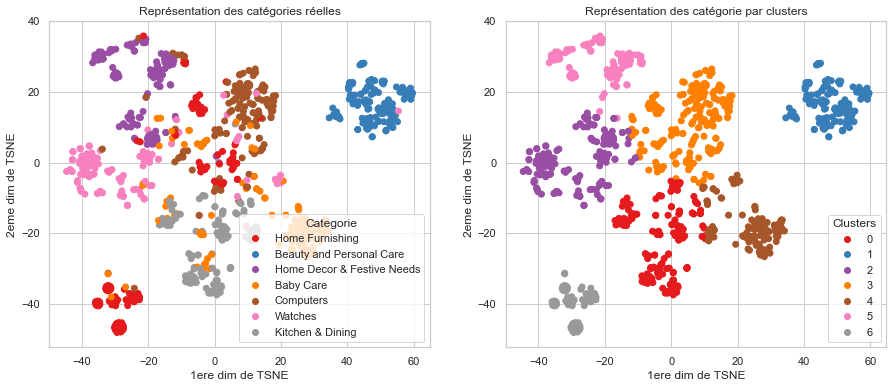

ARI :  0.5585


In [17]:
print("Tf-idf : ")
print("--------")
ARI, X_tsne, labels = ARI_fct(ctf_transform)
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)
X1_tsne=X_tsne

In [18]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim
import tensorflow_hub as hub
# Bert
import os
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

In [19]:
w2v_size=200
w2v_window=7
w2v_min_count=1
w2v_epochs=100
maxlen = 383 # adapt to length of sentences
sentences = data_text['sentence_bow_lem'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [20]:
w2v_min_count=1
maxlen = 383
sentences = data_text['sentence_bow_lem'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]
ari_max=0
epochs=100
for w2v_window in range(4,9):
    for w2v_size in range(240,341,10):
        w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                            vector_size=w2v_size,
                                            seed=42,
                                            workers=1)
        w2v_model.build_vocab(sentences)
        w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
        model_vectors = w2v_model.wv
        w2v_words = model_vectors.index_to_key
        tokenizer = Tokenizer()
        tokenizer.fit_on_texts(sentences)
        x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                 maxlen=maxlen,
                                                 padding='post') 
                                               
        num_words = len(tokenizer.word_index) + 1
        embedding_matrix = np.zeros((num_words, w2v_size))
        i=0
        j=0
        for word, idx in tokenizer.word_index.items():
            i +=1
            if word in w2v_words:
                j +=1
                embedding_vector = model_vectors[word]
                if embedding_vector is not None:
                    embedding_matrix[idx] = model_vectors[word]
                    
        word_rate = np.round(j/i,4)
        input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
        word_input=Input(shape=(maxlen,),dtype='float64')  
        word_embedding=Embedding(input_dim=num_words,
                                 output_dim=w2v_size,
                                 weights = [embedding_matrix],
                                 input_length=maxlen)(word_input)
        word_vec=GlobalAveragePooling1D()(word_embedding)  
        embed_model = Model([word_input],word_vec)
             
        embeddings = embed_model.predict(x_sentences)  
        ARI, X_tsne, labels = ARI_fct(embeddings)
        if ari_max<ARI:
            w2v_size_max=w2v_size
            w2v_window_max=w2v_window
            ari_max=ARI
            print('size = ',w2v_size_max,'window',w2v_window_max)
#print("ARI = ",ari_max,"w2v_size = ",w2v_size_max,"w2v_window = ",w2v_window_max,"w2v_epochs = ",w2v_epochs_max)
    

2022-08-12 14:57:44.083749: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-12 14:57:44.152582: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


ARI :  0.4374 time :  8.0
size =  240 window 4
ARI :  0.3738 time :  8.0
ARI :  0.3546 time :  8.0
ARI :  0.4129 time :  8.0
ARI :  0.3675 time :  8.0
ARI :  0.3676 time :  8.0
ARI :  0.3465 time :  7.0
ARI :  0.4122 time :  8.0
ARI :  0.3871 time :  8.0
ARI :  0.3634 time :  8.0
ARI :  0.4289 time :  8.0
ARI :  0.3491 time :  9.0
ARI :  0.3495 time :  9.0
ARI :  0.3615 time :  9.0
ARI :  0.3541 time :  9.0
ARI :  0.356 time :  9.0
ARI :  0.3471 time :  10.0
ARI :  0.3581 time :  9.0
ARI :  0.354 time :  9.0
ARI :  0.3494 time :  9.0
ARI :  0.4548 time :  8.0
size =  330 window 5
ARI :  0.349 time :  8.0
ARI :  0.3395 time :  8.0
ARI :  0.3315 time :  10.0
ARI :  0.3197 time :  12.0
ARI :  0.3493 time :  13.0
ARI :  0.3461 time :  13.0
ARI :  0.3323 time :  10.0
ARI :  0.3364 time :  14.0
ARI :  0.331 time :  11.0
ARI :  0.3404 time :  12.0
ARI :  0.3513 time :  12.0
ARI :  0.3387 time :  10.0
ARI :  0.3286 time :  10.0
ARI :  0.3311 time :  8.0
ARI :  0.3331 time :  9.0
ARI :  0.3342 

In [26]:
print("Build & train Word2Vec model ...")
w2v_window = w2v_window_max
w2v_size = w2v_size_max
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=1)

Build & train Word2Vec model ...


In [27]:
w2v_model.build_vocab(sentences)

In [28]:
# Création et entraînement du modèle Word2Vec
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Vocabulary size: 5062
Word2Vec trained


In [29]:
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 5063


In [30]:
print("Create Embedding matrix ...")
embedding_matrix = np.zeros((num_words, w2v_size))
i=0
j=0
for word, idx in tokenizer.word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (5063, 330)


In [31]:
input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=num_words,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_112 (InputLayer)       [(None, 383)]             0         
_________________________________________________________________
embedding_55 (Embedding)     (None, 383, 330)          1670790   
_________________________________________________________________
global_average_pooling1d_55  (None, 330)               0         
Total params: 1,670,790
Trainable params: 1,670,790
Non-trainable params: 0
_________________________________________________________________


In [32]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

(1050, 330)

Word2vect : 
--------
ARI :  0.4548 time :  7.0


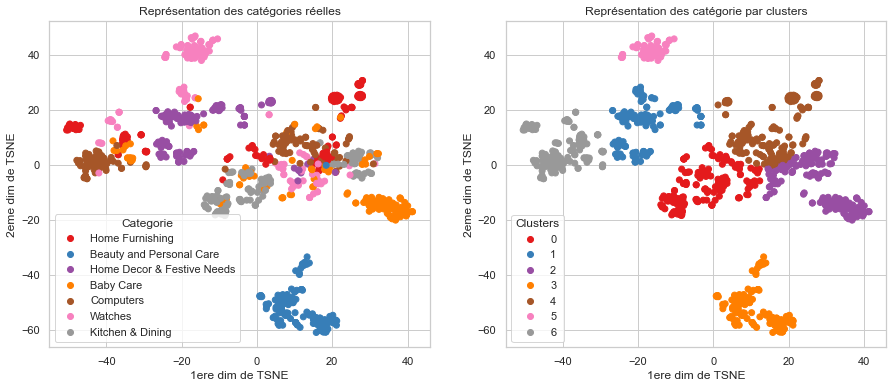

ARI :  0.4548


In [33]:
print("Word2vect : ")
print("--------")
ARI, X_tsne, labels = ARI_fct(embeddings)
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

In [34]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = data_text['sentence_dl'].to_list()

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /Users/zekrifaabdelmoumen/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/

In [35]:
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

In [40]:
ARI0=0
max_le=0
batch_si=0
for max_length in [32,64,128]:
    for batch_size in [8,9,10,11,12]:
        features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                                 max_length, batch_size, mode='HF')
        
        if features_bert.shape[0] == 1050:
            ARI, X_tsne, labels = ARI_fct(features_bert)
            if ARI0<ARI:
                ARI0=ARI
                max_le=max_length
                batch_si=batch_size
                print('max_length = ',max_length,'batch_size = ',batch_size)
#print(ARI0)
#features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
#                                                         max_le, batch_si, mode='HF')   

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /Users/zekrifaabdelmoumen/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-bas

temps traitement :  52.0


loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /Users/zekrifaabdelmoumen/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-bas

temps traitement :  50.0


loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /Users/zekrifaabdelmoumen/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-bas

temps traitement :  49.0
ARI :  0.4131 time :  9.0
max_length =  32 batch_size =  10


loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /Users/zekrifaabdelmoumen/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-bas

temps traitement :  50.0


loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /Users/zekrifaabdelmoumen/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-bas

temps traitement :  51.0


loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /Users/zekrifaabdelmoumen/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-bas

temps traitement :  106.0


loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /Users/zekrifaabdelmoumen/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-bas

temps traitement :  113.0


loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /Users/zekrifaabdelmoumen/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-bas

temps traitement :  110.0
ARI :  0.4694 time :  18.0
max_length =  64 batch_size =  10


loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /Users/zekrifaabdelmoumen/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-bas

temps traitement :  116.0


loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /Users/zekrifaabdelmoumen/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-bas

temps traitement :  103.0


loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /Users/zekrifaabdelmoumen/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-bas

temps traitement :  222.0


loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /Users/zekrifaabdelmoumen/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-bas

temps traitement :  212.0


loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /Users/zekrifaabdelmoumen/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-bas

temps traitement :  212.0
ARI :  0.3315 time :  10.0


loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /Users/zekrifaabdelmoumen/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-bas

temps traitement :  220.0


loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /Users/zekrifaabdelmoumen/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-bas

temps traitement :  210.0


In [41]:
features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_le, batch_si, mode='HF')

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /Users/zekrifaabdelmoumen/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-bas

temps traitement :  83.0


Bert : 
--------
ARI :  0.4694 time :  9.0


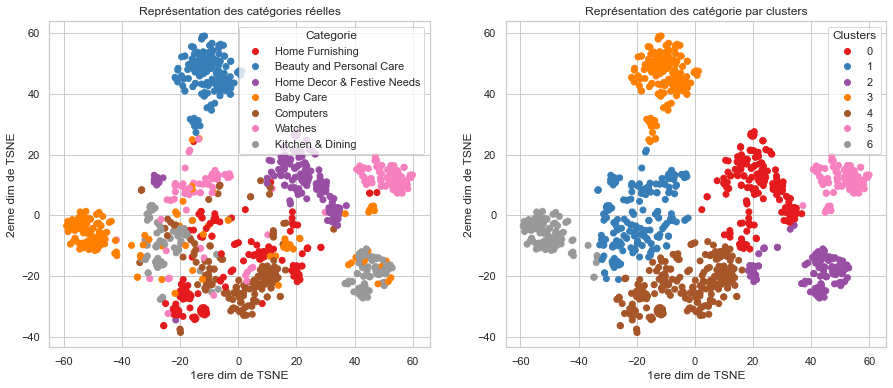

ARI :  0.4694


In [42]:
print("Bert : ")
print("--------")
ARI, X_tsne, labels = ARI_fct(features_bert)
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

In [43]:
max_length = 32
batch_size = 7
model_type = 'roberta-base'
model = TFAutoModel.from_pretrained(model_type)
sentences = data_text['sentence_dl'].to_list()

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /Users/zekrifaabdelmoumen/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file https://huggingfa

In [44]:
ARI0=0
max_le=0
batch_si=0
for max_length in [25,32,64]:
    for batch_size in [8,9,10,11,12]:
        features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                                 max_length, batch_size, mode='HF')
        
        if features_bert.shape[0] == 1050:
            ARI, X_tsne, labels = ARI_fct(features_bert)
            if ARI0<ARI:
                ARI0=ARI
                max_le=max_length
                batch_si=batch_size
print(ARI0)
print('max_length = ',max_le,'batch_size = ',batch_size)
features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_le, batch_si, mode='HF')       

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /Users/zekrifaabdelmoumen/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_s

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpzf4pnceg.py, line 140)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpzf4pnceg.py, line 140)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpggfwxjl5.py, line 10)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on 

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /Users/zekrifaabdelmoumen/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_s

temps traitement :  41.0


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /Users/zekrifaabdelmoumen/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_s

temps traitement :  45.0
ARI :  0.5075 time :  8.0


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /Users/zekrifaabdelmoumen/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_s

temps traitement :  41.0


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /Users/zekrifaabdelmoumen/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_s

temps traitement :  41.0


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /Users/zekrifaabdelmoumen/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_s

temps traitement :  60.0


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /Users/zekrifaabdelmoumen/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_s

temps traitement :  58.0


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /Users/zekrifaabdelmoumen/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_s

temps traitement :  56.0
ARI :  0.5021 time :  10.0


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /Users/zekrifaabdelmoumen/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_s

temps traitement :  54.0


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /Users/zekrifaabdelmoumen/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_s

temps traitement :  55.0


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /Users/zekrifaabdelmoumen/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_s

temps traitement :  107.0


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /Users/zekrifaabdelmoumen/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_s

temps traitement :  101.0


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /Users/zekrifaabdelmoumen/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_s

temps traitement :  99.0
ARI :  0.3812 time :  10.0


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /Users/zekrifaabdelmoumen/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_s

temps traitement :  101.0


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /Users/zekrifaabdelmoumen/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_s

temps traitement :  101.0
0.5075
max_length =  25 batch_size =  12


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /Users/zekrifaabdelmoumen/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_s

temps traitement :  49.0


RoBERTa : 
--------
ARI :  0.5075 time :  8.0


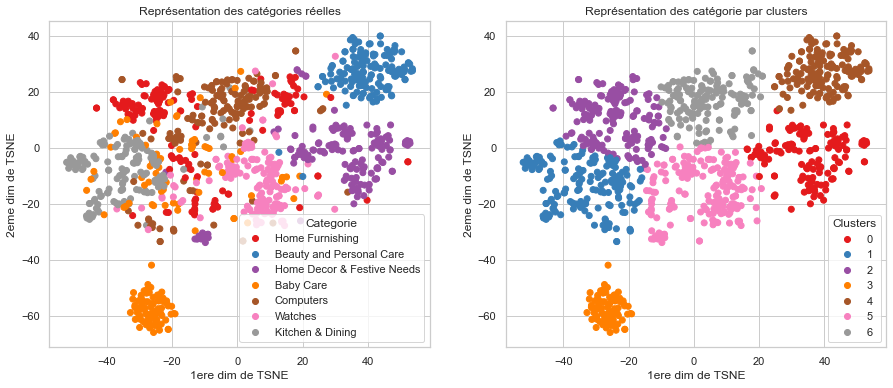

ARI :  0.5075


In [46]:
print("RoBERTa : ")
print("--------")
ARI, X_tsne, labels = ARI_fct(features_bert)
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)
X2_tsne=X_tsne

In [51]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

350

In [52]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [53]:
ARI0=0
for bac_s in [1,2,3,5,6,7,10]:
    features_USE = feature_USE_fct(sentences, bac_s)
    if features_USE.shape[0] == 1050: 
        print('batch_size = ',bac_s)
        ARI, X_tsne, labels = ARI_fct(features_USE)
        if ARI0 < ARI : 
            ARI0=ARI
            batch_size=bac_s
  

batch_size =  1
ARI :  0.4746 time :  7.0
batch_size =  2
ARI :  0.4505 time :  7.0
batch_size =  3
ARI :  0.4519 time :  8.0
batch_size =  5
ARI :  0.4685 time :  8.0
batch_size =  6
ARI :  0.4494 time :  8.0
batch_size =  7
ARI :  0.4489 time :  8.0
batch_size =  10
ARI :  0.4272 time :  9.0


USE : 
--------
ARI :  0.4746 time :  8.0


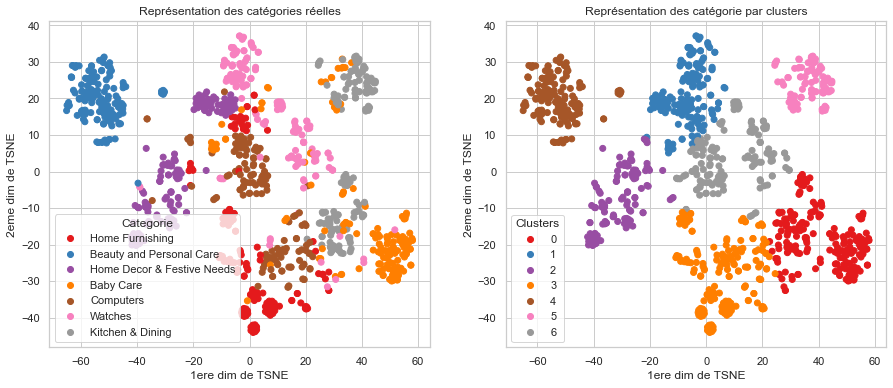

ARI :  0.4746


In [55]:
features_USE = feature_USE_fct(sentences, batch_size)
print("USE : ")
print("--------")
ARI, X_tsne, labels = ARI_fct(features_USE)
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)
X3_tsne=X_tsne

# Partie Image

In [56]:
import imageio
import cv2

In [57]:
img=imageio.v2.imread('Flipkart/Images/0bff0eda7a6677dc1acb0477a1f7a121.jpg')

In [58]:
img1=cv2.GaussianBlur(img,(5,5),0)

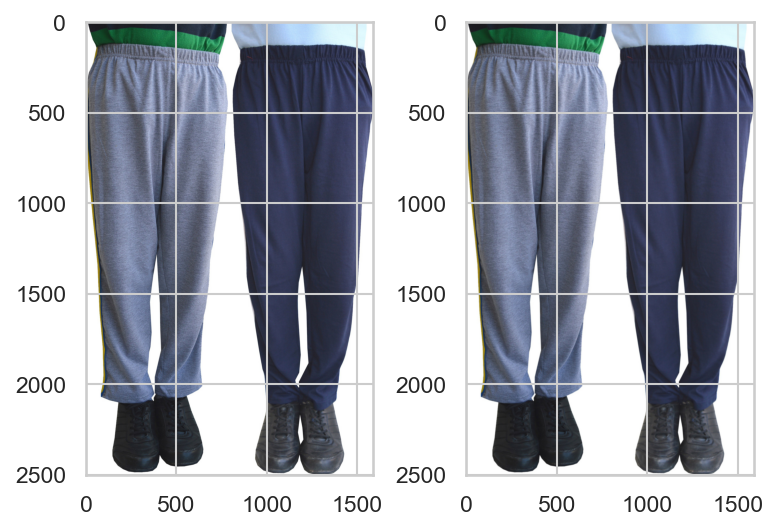

In [59]:
plt.figure(dpi=150)
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(img1)

In [60]:
img2=cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
sift = cv2.xfeatures2d.SIFT_create()
kp, desc = sift.detectAndCompute(img2, None)

[ WARN:0] global /Users/runner/miniforge3/conda-bld/libopencv_1619749239158/work/opencv_contrib/modules/xfeatures2d/misc/python/shadow_sift.hpp (15) SIFT_create DEPRECATED: cv.xfeatures2d.SIFT_create() is deprecated due SIFT tranfer to the main repository. https://github.com/opencv/opencv/issues/16736


In [67]:
def Load_image_sift(path):
    im = cv2.imread(path)
    im = cv2.GaussianBlur(im,(5,5),0)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    maxi= np.max(im)
    mini= np.min(im)
    im = ((im - mini)/(maxi-mini))*256
    im = im.astype(np.uint8)
    return im

def feature_sift_fct(images) :
    sift = cv2.xfeatures2d.SIFT_create()
    desc_list=[]
    l=len(images)
    for img in images :
        kp,desc=sift.detectAndCompute(img, None)
        desc_list.append(desc)
        if((len(desc_list))%50==0):
            print(len(desc_list),' images are computed')
    
    total_desc=np.concatenate(desc_list,axis=0)
    print(total_desc.shape)
    return desc_list, total_desc
def fit_trans_desc(desc_list, total_desc,scaler,pca):
    total_desc_trans=scaler.fit_transform(total_desc)
    pca.fit(total_desc_trans)
    lim=kaiser_lim(pca)
    total_desc_trans = pca.transform(total_desc_trans)
    total_desc_trans = total_desc_trans[:,:lim]
    desc_list_trans=[]
    for desc in desc_list:
        X_std=scaler.transform(desc)
        X_std = pca.transform(X_std)
        X_std = X_std[:,:lim]
        desc_list_trans.append(X_std)
    return desc_list_trans ,total_desc_trans
def embedding_sift(desc_list_trans ,total_desc_trans,n_dic):
    random_state = 1
    kmeans_model = KMeans(n_clusters=n_dic, 
                      verbose=False, 
                      init='random',
                      random_state=random_state, 
                      n_init=3)
    kmeans_model.fit(total_desc_trans)
    l=len(desc_list_trans)
    embeddings = np.zeros((l,n_dic))
    i=0
    for X_projec in desc_list_trans:
        cls=kmeans_model.predict(X_projec)
        for j in cls:
            embeddings[i][j]+=1
        i+=1
    print(embeddings.shape)
    return embeddings
    
    

In [64]:
data_img['path']=data_img['uniq_id'].apply(lambda x: f'Flipkart/Images/{x}.jpg')
print('address loaded')
data_img['image_sift']=data_img['path'].apply(lambda x : Load_image_sift(x))

address loaded


In [65]:
images=data_img['image_sift'].to_list()

In [66]:
desc_list, total_desc = feature_sift_fct(images)

50  images are computed
100  images are computed
150  images are computed
200  images are computed
250  images are computed
300  images are computed
350  images are computed
400  images are computed
450  images are computed
500  images are computed
550  images are computed
600  images are computed
650  images are computed
700  images are computed
750  images are computed
800  images are computed
850  images are computed
900  images are computed
950  images are computed
1000  images are computed
1050  images are computed
(4956421, 128)


In [68]:
pca = decomposition.PCA(n_components=128)
scaler=StandardScaler()
desc_list, total_desc = fit_trans_desc(desc_list, total_desc,scaler,pca)

(1050, 70)
70
ARI :  0.0542 time :  11.0


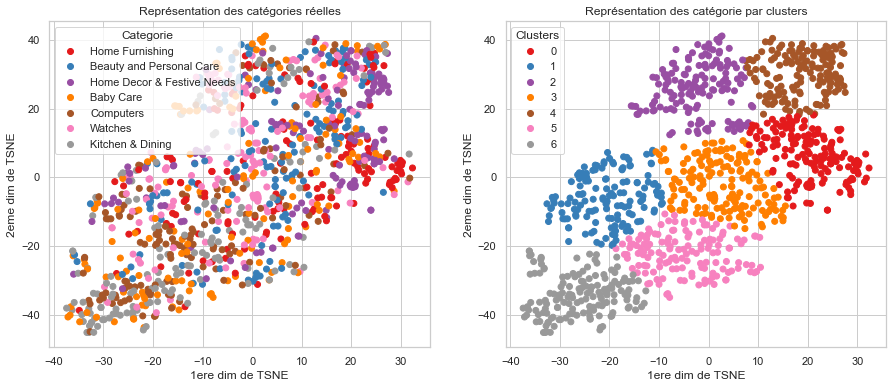

ARI :  0.0542


In [69]:
n_dic = 70
embeddings=embedding_sift(desc_list ,total_desc,n_dic)
print(n_dic)
ARI, X_tsne, labels = ARI_fct(embeddings)
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

In [70]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16


In [71]:
# load model
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

In [72]:
def Load_image_VGG16(path):
    image = load_img(path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    return image

In [73]:
data_img['image_VGG16'] = data_img['path'].apply(lambda x : Load_image_VGG16(x))

In [74]:
data_img['feat_VGG16'] = data_img['image_VGG16'].apply(lambda x : model.predict(x))

In [75]:
embeddings=np.concatenate(data_img['feat_VGG16'])
embeddings.shape

(1050, 4096)

ARI :  0.4393 time :  11.0


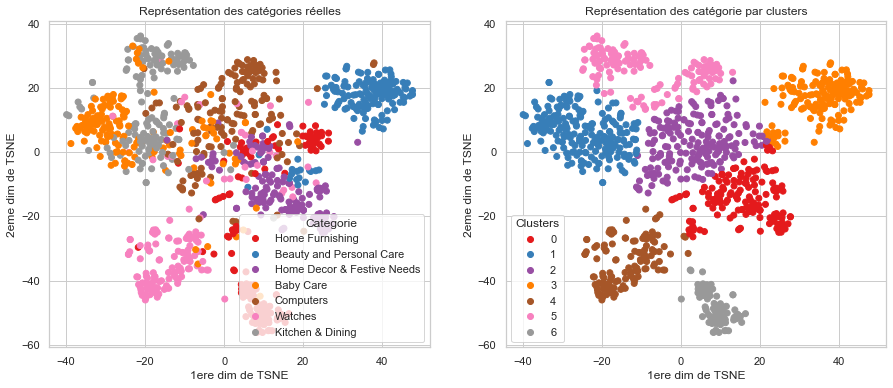

ARI :  0.4393


In [76]:
ARI, X_tsne, labels = ARI_fct(embeddings)
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

In [77]:
X4_tsne=X_tsne

In [110]:
X_tsne=np.concatenate([X2_tsne, X3_tsne,X1_tsne,X4_tsne],axis=1)
X_tsne

array([[-43.696407  , -18.33852   ,  31.982578  , ..., -20.897354  ,
        -13.222179  ,  29.157253  ],
       [-24.935944  ,  -9.095378  ,  33.263275  , ..., -17.007488  ,
        -17.93595   ,   6.2627225 ],
       [-22.694777  , -14.897991  ,  33.406315  , ..., -14.864159  ,
        -22.126385  ,   2.9154372 ],
       ...,
       [ -8.640944  ,  -0.20689937, -13.561467  , ...,   5.319868  ,
         -5.191483  ,   7.689771  ],
       [-14.018501  ,   1.0377358 , -12.855157  , ...,   5.462821  ,
         -3.353667  ,   9.76524   ],
       [ -9.344155  ,   0.15658338, -13.383716  , ...,   5.201582  ,
         -2.663719  ,   5.8735213 ]], dtype=float32)

In [111]:
cls = KMeans(n_clusters=7, n_init=100, random_state=42)
cls.fit(X_tsne)
ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
print(ARI)

0.6502


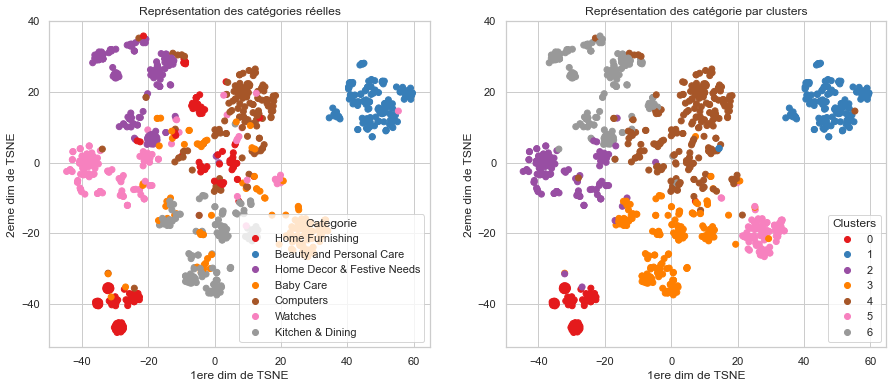

ARI :  0.6502


In [80]:
TSNE_visu_fct(X1_tsne, y_cat_num, cls.labels_, ARI)

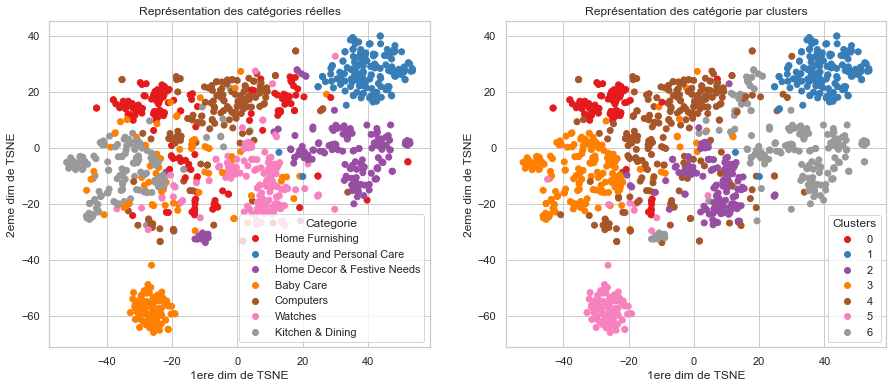

ARI :  0.6502


In [119]:
TSNE_visu_fct(X2_tsne, y_cat_num, cls.labels_, ARI)